# Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import bisect

# Load Image

array([[122, 121, 121, ...,  69,  71,  73],
       [120, 119, 117, ...,  72,  73,  76],
       [113, 113, 114, ...,  74,  77,  79],
       ...,
       [114,  96,  84, ...,  72,  68,  69],
       [ 96,  84,  77, ...,  72,  68,  69],
       [ 84,  77,  91, ...,  72,  68,  69]], dtype=uint8)
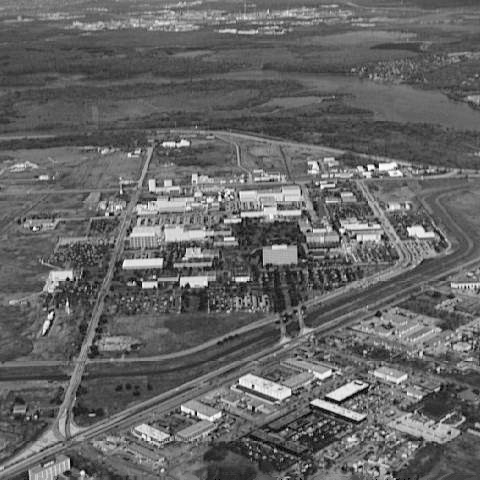

In [ ]:
# 讀取圖片
img = cv2.imread('aerial_view.tif', cv2.IMREAD_GRAYSCALE)
img

# Useful Fucntions

In [ ]:
"""
Note: 
    The variables mentioned below are all from the textbook: 
    R. C. Gonzalez and R. E. Woods, "Digital Image Processing," 4th ed. (PIE) Pearson Prentice Hall, 2018
    
    Please check Section 3.3 Histogram Processing in the book.
"""

def show_plot(image, title):
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.subplot(122)
    plt.hist(image.ravel(), bins=256, range=(0, 256))
    plt.title('Histogram')
    plt.show()

def histEqualization(image):
    # get histogram of the image
    """
        n_k: number of pixels that have intensity r_k
        
        hist: n_k
    """
    hist, _ = np.histogram(image.flatten(), 256, [0, 255])
    
    # calculate the PDF
    """
        p_r(r_k): the probability of occurrence of intensity level r_k in a digital image
        M * N: the total number of picels in the image (in this homework, M * N = 480 * 480)
        
        pdf: p_r(r_k) = n_k / (M * N)
    """
    pdf = hist / (image.shape[0] * image.shape[1])
    
    # calculate the CDF
    """
        CDF: sum of the PDF
    """
    cdf = pdf.cumsum()
    
    # calculate the s_k
    """
        L: the number of possible intensity levels in the image (in this homework, L = 256 (8-bit image))
        
        s_k = (L - 1) * CDF
        
        However, we will get float values by using the s_k function above directly.
        Therefore, we have to round them to the nearest whole number.
    """
    s_k = np.round(255 * cdf)
    
    # convert the original image by the s_k
    image_new = s_k[image]
    
    # change the number type from float to int
    return image_new.astype(int)

def histMatching(image):
    # calculate the c
    """
        The question gave us the PDF. Because the sum of the PDF is 1, we can use this feature the get c.
        
        SUM{PDF} = SUM{p_z(z_q)} = SUM{c * ( (z_q)^0.4 )} = c * SUM{ (z_q)^0.4 } = 1
        c = 1 / SUM{ (z_q)^0.4 }
        z_q: 0 ~ (L-1), in this homework, 0 ~ 255
    """
    z = np.arange(256)
    sum_z = np.sum(z**0.4)
    c = 1 / sum_z

    """
        To do the Histogram Matching, we need G(z_q) and s_k, and try to find the relationship between them,
        making G(z_q) = s_k such that we can match original image to the target.
        
        target_s_k: G(z_q)
        orginal_s_k: s_k
    """
    # get the G function from target image
    target_pdf = c * (z**0.4)
    target_cdf = target_pdf.cumsum()
    target_s_k = np.round(255 * target_cdf)

    # get the s_k function from original image
    original_hist, _ = np.histogram(image.flatten(), 256, [0, 255])
    original_cdf = (original_hist / (image.shape[0] * image.shape[1])).cumsum()
    original_s_k = np.round(255 * original_cdf)

    """
        For all s_k values, we try to find whether it is in the G(z_q).
        There are three cases:
        (1) s_k = G(z_q)
        (2) s_k != G(z_q), we choose the nearest G(z_q)
            e.g. s_2 = 4, G(z_7) = 2, G(z_8) = 5, G(z_8) is closer than G(z_7), thus we map 2 to 8.
            
        (3) s_k != G(z_q), and the distance between the smaller G(z_q) and s_k, larger G(z_q) and s_k 
            are the same, we choose the smaller G(z_q)
            e.g. s_2 = 4, G(z_7) = 2, G(z_8) = 6, G(z_8) is closer than G(z_7), thus we map 2 to 7.
    """
    def find_closest_index(sorted_list, value):
        # Find the nearest value position in the sorted_list
        idx = bisect.bisect_left(sorted_list, value)

        if idx == 0:
            return 0  # If the value <= min(sorted_list), return 0
        elif idx == len(sorted_list):
            return len(sorted_list) - 1  # If the value > max(sorted_list), return last index
        else:
            # Choose the closest value position
            prev_val = sorted_list[idx - 1]
            next_val = sorted_list[idx]
            if abs(prev_val - value) <= abs(next_val - value):
                return idx - 1
            else:
                return idx
    
    # map k to q
    def map_indexes(original_s_k, target_s_k):
        mapping = [0] * len(original_s_k) 
        for i, val in enumerate(original_s_k):
            closest_idx = find_closest_index(target_s_k, val)
            mapping[i] = closest_idx
        return mapping

    # mapping function
    mapping = np.array(map_indexes(original_s_k, target_s_k))
    
    # convert original image using mapping function
    image_new = mapping[image]
    
    # change the number type from float to int
    return image_new.astype(int)

### 1. Please depict the histogram and graph of the assigned image “aerial_view.tif”, and print out the source code? (10)

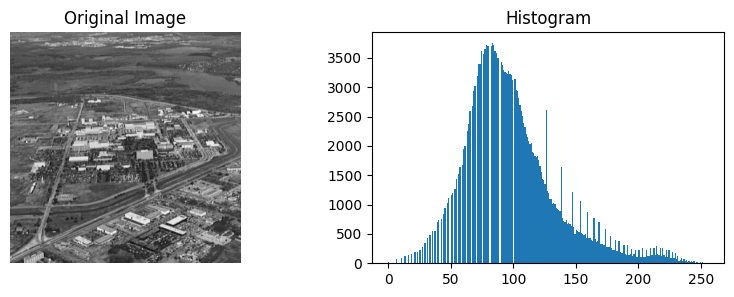

In [ ]:
show_plot(img, 'Original Image')

### 2. Please plot the histogram and graph of the image after Histogram Equalization, and print out the source code? (30)

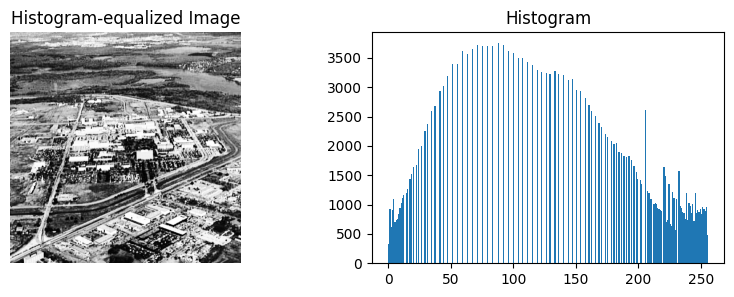

In [ ]:
equalized_img = histEqualization(img)
show_plot(equalized_img, 'Histogram-equalized Image')

### 3. Please plot the histogram and graph of the image after Histogram Matching (specification) by $p_z(z_q)=c∙z_q^{0.4}$, and print out the source code? (NOTE: the parameter, c, needs to calculate in advance) (40)

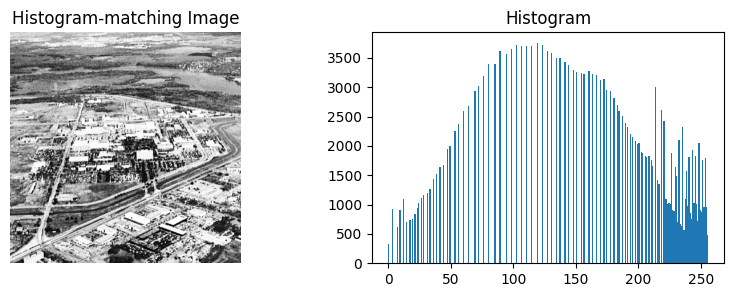

In [ ]:
matched_img = histMatching(img)
show_plot(matched_img, 'Histogram-matching Image')

# 4. Show images and histograms in a picture

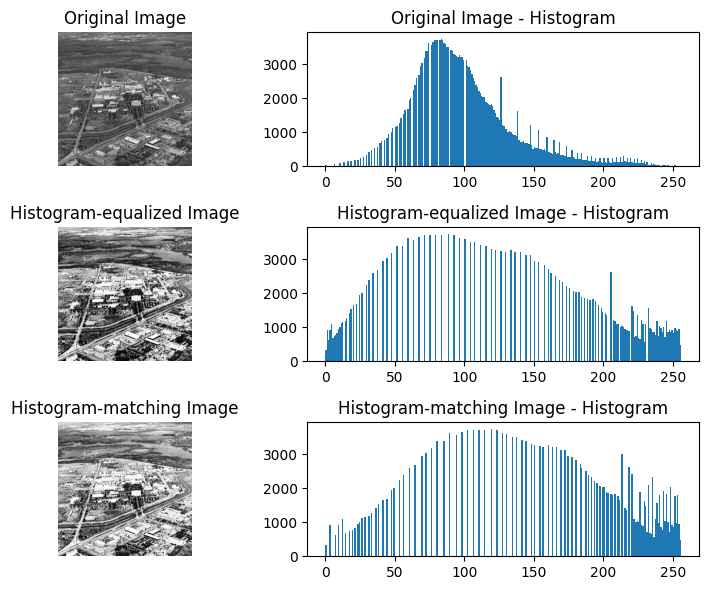

In [ ]:
def show_plots_in_1(images, titles):
    plt.figure(figsize=(8, 6))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(len(images), 2, 2 * i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')

        plt.subplot(len(images), 2, 2 * i + 2)
        plt.hist(image.ravel(), bins=256, range=(0, 256))
        plt.title(f'{title} - Histogram')

    plt.tight_layout()
    plt.show()

equalized_img = histEqualization(img)
matched_img = histMatching(img)

show_plots_in_1([img, equalized_img, matched_img], ['Original Image', 'Histogram-equalized Image', 'Histogram-matching Image'])